In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!python3 -c "import torch; print(torch.__version__)"

!pip3 install networkx

2.1.0+cu121


In [ ]:
#!pip3 install torch torchvision
import torch
import torch.nn as nn
import numpy as np
from numpy import inf
from tqdm import tqdm

from timeit import default_timer as timer

import networkx as nx

import matplotlib.pyplot as plt
import pickle

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(0)

In [ ]:
class BaseGNNLayer(nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()
        lim = 1
        self.w_self = (-2 * lim * torch.rand(input_dim, output_dim) + lim).to(device)
        self.w_neigh = (-2 * lim * torch.rand(input_dim, output_dim) + lim).to(device)

    def forward(self, node_feats, adj_matrix):
        node_feats_self = torch.mm(node_feats, self.w_self)
        node_feats_neigh = torch.mm(torch.mm(adj_matrix, node_feats), self.w_neigh)

        next_node_feats = node_feats_self + \
                        node_feats_neigh
        return next_node_feats

In [ ]:
# Truncated Sigmoid
threshold = 1
def act_fn(x):
    return torch.clamp(x, min=-threshold, max=threshold)

In [ ]:
class BaseGNNModule(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=act_fn):
        super().__init__()
        self.layers = nn.ModuleList([BaseGNNLayer(input_dim, hidden_dim)]).to(device)
        for i in range(num_layers - 2):
            self.layers.append(BaseGNNLayer(hidden_dim, hidden_dim).to(device))
        self.layers.append(BaseGNNLayer(hidden_dim, output_dim).to(device))
        self.act_fn = act_fn

    def forward(self, x, adj_matrix):

        for layer in self.layers:
            x = self.act_fn(layer(x, adj_matrix))
        return x

In [ ]:
class MLPModule(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=torch.tanh):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_dim, hidden_dim)]).to(device)
        for i in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim).to(device))
        self.layers.append(nn.Linear(hidden_dim, output_dim).to(device))
        self.act_fn = act_fn

    def forward(self, x):
        for layer in self.layers:
            x = self.act_fn(layer(x))
        return torch.sigmoid(x)

In [ ]:
def loader(A):
  n = len(A)
  for i in range(n):
    yield A[i]

# Model Evaluation

In [ ]:
def get_csv(graph_func, NUM_NODES, d=64, r=0.5, layers=[3], num_models=10, calc_adj_upfront=True):
  """
  graph_func(graph_dim, r) -> adj_matrix
  """
  csv = []
  # Calculate graphs upfront
  A = [];
  if calc_adj_upfront:
    for graph_dim in NUM_NODES:
        start_time = timer()
        for idx in range(2**5):
            A.append(graph_func(graph_dim, r))
        print(f'Graphs of size {graph_dim} generated in {timer()-start_time}')
    print(f"Generated {len(A)} graphs.")

  for num_layers in layers:
    for mpnn_idx in range(num_models):  # There will be 10 plots.
        # Initialize random BaseGNN model with sum aggregation.
        base_gnn = BaseGNNModule(input_dim=d, hidden_dim=d, output_dim=7,
                                num_layers=num_layers, act_fn=act_fn).to(device)

        # Initialize random MLP classifier acting on final mean-pooled embedding.
        mlp = MLPModule(input_dim=7, hidden_dim=100, output_dim=1,
                    num_layers=2, act_fn=torch.tanh).to(device)

        proportions = []
        adj_loader = loader(A)
        # Create plot with x-axis an increasing seq of number of graph nodes.
        for graph_dim in NUM_NODES:
            classifications_1 = 0
            total_number = 0

            for idx in range(2**5):
                # Generate graph to be fed to the BaseGNN.

                #adj_matrix = graph_func(graph_dim, r).to(device)
                if calc_adj_upfront:
                    adj_matrix = next(adj_loader).to(device)
                else:
                    adj_matrix = graph_func(graph_dim, r).to(device)
                #assert adj_matrix.size(dim=0) == graph_dim
                initial_node_feats = torch.rand(graph_dim, d).to(device)

                # Obtain final mean-pooled embedding vector over all graph_dim nodes.
                output = base_gnn(initial_node_feats, adj_matrix)

                # Apply MLP classifier to the resulting output.
                output = mlp(output)

                # If smaller than 1/2, output 0, else output 1.
                classifications_1 += (output >= 0.5).count_nonzero().item()
                total_number += output.size(0)

        # Calculate proportion of graphs classified as 1.
            proportions.append(classifications_1/total_number)

        csv.append([d,r,num_layers, mpnn_idx, proportions])
        print(csv[-1])
  return csv

# Plotting function

In [35]:
def plot_csv(csv_layers, num_samples, subtitles, xx, log_scale=True, title=""):
  num_plots = len(csv_layers)
  fig, axs = plt.subplots(1, num_plots, figsize=(20,5))

  for i, csv_layer in enumerate(csv_layers):#, csv_numLayer_2, csv_numLayer_3]):
    csv_layer = [item[-1] for item in csv_layer]
    for y in csv_layer:
      #y = [item/num_samples for item in y]
      axs[i].plot(xx[i], y)
    axs[i].set_xlabel('Graph sizes')
    axs[i].set_ylabel('Fraction of nodes classified as 1')
    if log_scale:
      axs[i].set_xscale("log")
    axs[i].set_title(subtitles[i], fontsize=16)

  fig.suptitle(title, fontsize=20)
  fig.show()

In [ ]:
def get_er_graph(graph_dim, r):
  half_matrix = torch.bernoulli(r * (torch.triu(torch.ones(graph_dim, graph_dim)) -
                                     torch.eye(graph_dim)))
  adj_matrix = half_matrix + half_matrix.T
  return adj_matrix

def get_ba_graph(graph_dim, r=None):
  G = nx.barabasi_albert_graph(graph_dim, 3)#, graph_dim // 2)
  A = nx.adjacency_matrix(G)
  adj_matrix = torch.tensor(A.todense()).float() #.to(device)
  return adj_matrix

def get_their_ba_graph(graph_dim, r=None):
  G = nx.barabasi_albert_graph(graph_dim, graph_dim //2)#, graph_dim // 2)
  A = nx.adjacency_matrix(G)
  adj_matrix = torch.tensor(A.todense()).float() #.to(device)
  return adj_matrix

def get_regular_graph(graph_dim, r = None):
  G = nx.random_regular_graph(d=3, n=graph_dim)
  A = nx.adjacency_matrix(G)
  adj_matrix = torch.tensor(A.todense()).float() #.to(device)
  return adj_matrix

def get_ext_ba_graph(graph_dim, r = None):
  G = nx.extended_barabasi_albert_graph(n=graph_dim, m=1, p=0.5, q=0.1)
  A = nx.adjacency_matrix(G)
  adj_matrix = torch.tensor(A.todense()).float() #.to(device)
  return adj_matrix

# Evaluate and Plot

Erdos-Renyi

In [ ]:
NUM_NODES_er = [10, 50, 100, 500, 1000, 2000, 5000, 10000]
csv_er = get_csv(get_er_graph, NUM_NODES_er, calc_adj_upfront=False)

[64, 0.5, 3, 0, [0.834375, 0.804375, 0.8759375, 1.0, 1.0, 1.0, 1.0, 1.0]]
[64, 0.5, 3, 1, [0.33125, 0.0525, 0.0, 0.1875, 0.21875, 0.125, 0.03125, 0.0]]
[64, 0.5, 3, 2, [0.7375, 0.051875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
[64, 0.5, 3, 3, [0.140625, 0.05875, 0.1053125, 0.5585625, 0.875, 1.0, 1.0, 1.0]]
[64, 0.5, 3, 4, [0.828125, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
[64, 0.5, 3, 5, [0.684375, 0.76625, 0.8125, 0.7811875, 0.875, 1.0, 1.0, 1.0]]
[64, 0.5, 3, 6, [0.86875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
[64, 0.5, 3, 7, [0.328125, 0.6725, 0.7946875, 0.662375, 0.8125, 0.875, 0.90625, 0.90625]]
[64, 0.5, 3, 8, [0.440625, 0.30875, 0.250625, 0.094, 0.125, 0.03125, 0.03125, 0.0625]]
[64, 0.5, 3, 9, [0.015625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


BA

In [ ]:
### BA GRAPH
NUM_NODES_ba = [10, 50, 100, 500, 1000, 1500, 2000]
csv_ba = get_csv(get_ba_graph, NUM_NODES_ba)

Graphs of size 10 generated in 0.01671538899972802
Graphs of size 50 generated in 0.03336355400006141
Graphs of size 100 generated in 0.2114756609998949
Graphs of size 500 generated in 0.22503030899997611
Graphs of size 1000 generated in 0.4851497019999442
Graphs of size 1500 generated in 1.7885707159998674
Graphs of size 2000 generated in 2.4542662170001677
Generated 224 graphs.
[64, 0.5, 3, 0, [0.5, 0.645, 0.7371875, 0.7594375, 0.7528125, 0.7796875, 0.777828125]]
[64, 0.5, 3, 1, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
[64, 0.5, 3, 2, [0.284375, 0.08375, 0.1196875, 0.1194375, 0.113, 0.1006875, 0.101125]]
[64, 0.5, 3, 3, [1.0, 0.998125, 0.9990625, 0.9993125, 0.99928125, 0.999375, 0.999265625]]
[64, 0.5, 3, 4, [0.825, 0.696875, 0.6465625, 0.64425, 0.6441875, 0.6409791666666667, 0.637734375]]
[64, 0.5, 3, 5, [0.3125, 0.1675, 0.205625, 0.19825, 0.221625, 0.19679166666666667, 0.2065]]
[64, 0.5, 3, 6, [0.990625, 0.99875, 0.9990625, 0.999875, 0.9996875, 0.9996875, 0.999796875]]
[64, 0.5, 3, 7, 

In [37]:

NUM_NODES_ba_their = [10, 50, 100, 500, 1000, 1500, 2000]
csv_their_ba = get_csv(get_their_ba_graph, NUM_NODES_ba)

Graphs of size 10 generated in 0.018743459000233997
Graphs of size 50 generated in 0.09404100800020387
Graphs of size 100 generated in 0.33493268900019757
Graphs of size 500 generated in 11.749969160000092
Graphs of size 1000 generated in 46.088930223999796
Graphs of size 1500 generated in 108.87892244199975
Graphs of size 2000 generated in 192.47312091300046
Generated 224 graphs.
[64, 0.5, 3, 0, [0.0, 0.1275, 0.0, 0.0, 0.0, 0.0, 0.0]]
[64, 0.5, 3, 1, [0.3125, 0.154375, 0.09375, 0.0389375, 0.0, 0.0, 0.0]]
[64, 0.5, 3, 2, [0.6125, 0.22625, 0.4128125, 0.2641875, 0.14378125, 0.015625, 0.046875]]
[64, 0.5, 3, 3, [0.5375, 0.42875, 0.3425, 0.1638125, 0.15315625, 0.015625, 0.015625]]
[64, 0.5, 3, 4, [0.36875, 0.666875, 0.593125, 0.73525, 0.81128125, 0.8468125, 0.844046875]]
[64, 0.5, 3, 5, [0.925, 0.999375, 1.0, 0.977, 0.9375, 0.9835416666666666, 0.928046875]]
[64, 0.5, 3, 6, [0.509375, 0.385, 0.2828125, 0.2715, 0.184875, 0.15352083333333333, 0.03125]]
[64, 0.5, 3, 7, [0.959375, 1.0, 1.0, 1.0

Extended BA

In [ ]:
## Extended BA model
# https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.extended_barabasi_albert_graph.html#extended-barabasi-albert-graph
NUM_NODES_ext = [10, 50, 100, 500, 1000, 1500]
csv_ext_ba = get_csv(get_ext_ba_graph, NUM_NODES_ext)

Graphs of size 10 generated in 0.030005421000169008
Graphs of size 50 generated in 0.25111636000019644
Graphs of size 100 generated in 0.5812920529997427
Graphs of size 500 generated in 6.733770001000266
Graphs of size 1000 generated in 26.562512778000382
Graphs of size 1500 generated in 62.53289826299988
Generated 192 graphs.
[64, 0.5, 3, 0, [0.009375, 0.014375, 0.00875, 0.01025, 0.0109375, 0.010541666666666666]]
[64, 0.5, 3, 1, [0.44375, 0.575, 0.5584375, 0.6170625, 0.62665625, 0.6357916666666666]]
[64, 0.5, 3, 2, [0.296875, 0.285, 0.3284375, 0.33825, 0.3433125, 0.3545]]
[64, 0.5, 3, 3, [0.965625, 0.950625, 0.93875, 0.953125, 0.9503125, 0.9534583333333333]]
[64, 0.5, 3, 4, [0.571875, 0.57625, 0.5275, 0.535625, 0.5498125, 0.5314791666666666]]
[64, 0.5, 3, 5, [0.0125, 0.01125, 0.010625, 0.012625, 0.01390625, 0.013375]]
[64, 0.5, 3, 6, [0.353125, 0.225, 0.1746875, 0.1604375, 0.16096875, 0.15425]]
[64, 0.5, 3, 7, [0.3, 0.091875, 0.0846875, 0.06525, 0.07240625, 0.06920833333333333]]
[64, 

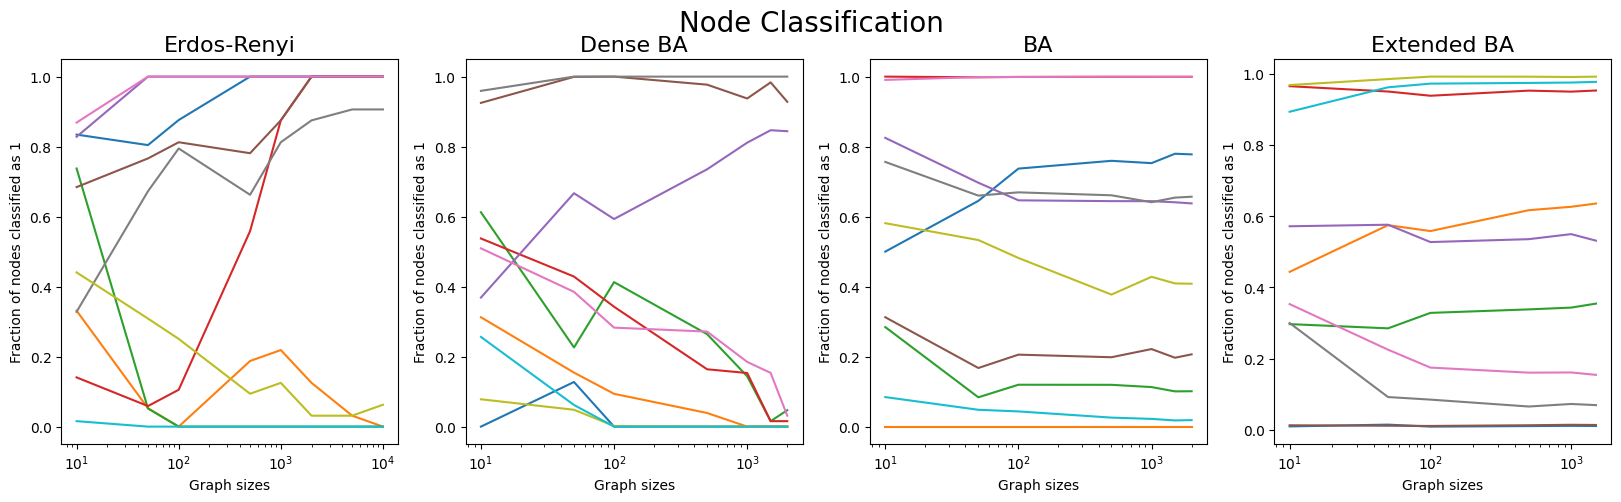

In [38]:

csv = [csv_er, csv_their_ba, csv_ba, csv_ext_ba]
model_names = ["Erdos-Renyi", "Dense BA", "BA", "Extended BA"]
graph_range = [NUM_NODES_er, NUM_NODES_ba_their, NUM_NODES_ba, NUM_NODES_ext]
plot_csv(csv, 32, log_scale=True, title="Node Classification", subtitles=model_names, xx = graph_range)

In [26]:
csv_er = [[64, 0.5, 3, 0, [0.834375, 0.804375, 0.8759375, 1.0, 1.0, 1.0, 1.0, 1.0]],
 [64, 0.5, 3, 1, [0.33125, 0.0525, 0.0, 0.1875, 0.21875, 0.125, 0.03125, 0.0]],
 [64, 0.5, 3, 2, [0.7375, 0.051875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
 [64,
  0.5,
  3,
  3,
  [0.140625, 0.05875, 0.1053125, 0.5585625, 0.875, 1.0, 1.0, 1.0]],
 [64, 0.5, 3, 4, [0.828125, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]],
 [64, 0.5, 3, 5, [0.684375, 0.76625, 0.8125, 0.7811875, 0.875, 1.0, 1.0, 1.0]],
 [64, 0.5, 3, 6, [0.86875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]],
 [64,
  0.5,
  3,
  7,
  [0.328125, 0.6725, 0.7946875, 0.662375, 0.8125, 0.875, 0.90625, 0.90625]],
 [64,
  0.5,
  3,
  8,
  [0.440625, 0.30875, 0.250625, 0.094, 0.125, 0.03125, 0.03125, 0.0625]],
 [64, 0.5, 3, 9, [0.015625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]]

[[64, 0.5, 3, 0, [0.834375, 0.804375, 0.8759375, 1.0, 1.0, 1.0, 1.0, 1.0]],
 [64, 0.5, 3, 1, [0.33125, 0.0525, 0.0, 0.1875, 0.21875, 0.125, 0.03125, 0.0]],
 [64, 0.5, 3, 2, [0.7375, 0.051875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
 [64,
  0.5,
  3,
  3,
  [0.140625, 0.05875, 0.1053125, 0.5585625, 0.875, 1.0, 1.0, 1.0]],
 [64, 0.5, 3, 4, [0.828125, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]],
 [64, 0.5, 3, 5, [0.684375, 0.76625, 0.8125, 0.7811875, 0.875, 1.0, 1.0, 1.0]],
 [64, 0.5, 3, 6, [0.86875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]],
 [64,
  0.5,
  3,
  7,
  [0.328125, 0.6725, 0.7946875, 0.662375, 0.8125, 0.875, 0.90625, 0.90625]],
 [64,
  0.5,
  3,
  8,
  [0.440625, 0.30875, 0.250625, 0.094, 0.125, 0.03125, 0.03125, 0.0625]],
 [64, 0.5, 3, 9, [0.015625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]]

In [30]:
csv_ba = [[64, 0.5, 3, 0, [0.5, 0.645, 0.7371875, 0.7594375, 0.7528125, 0.7796875, 0.777828125]], [64, 0.5, 3, 1, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [64, 0.5, 3, 2, [0.284375, 0.08375, 0.1196875, 0.1194375, 0.113, 0.1006875, 0.101125]], [64, 0.5, 3, 3, [1.0, 0.998125, 0.9990625, 0.9993125, 0.99928125, 0.999375, 0.999265625]], [64, 0.5, 3, 4, [0.825, 0.696875, 0.6465625, 0.64425, 0.6441875, 0.6409791666666667, 0.637734375]], [64, 0.5, 3, 5, [0.3125, 0.1675, 0.205625, 0.19825, 0.221625, 0.19679166666666667, 0.2065]], [64, 0.5, 3, 6, [0.990625, 0.99875, 0.9990625, 0.999875, 0.9996875, 0.9996875, 0.999796875]], [64, 0.5, 3, 7, [0.75625, 0.66, 0.669375, 0.6609375, 0.64125, 0.6543125, 0.65684375]], [64, 0.5, 3, 8, [0.58125, 0.533125, 0.481875, 0.37725, 0.4280625, 0.4091666666666667, 0.40825]], [64, 0.5, 3, 9, [0.084375, 0.048125, 0.0434375, 0.02575, 0.02209375, 0.0176875, 0.018578125]]]


[[64, 0.5, 3, 0, [0.5, 0.645, 0.7371875, 0.7594375, 0.7528125, 0.7796875, 0.777828125]], [64, 0.5, 3, 1, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [64, 0.5, 3, 2, [0.284375, 0.08375, 0.1196875, 0.1194375, 0.113, 0.1006875, 0.101125]], [64, 0.5, 3, 3, [1.0, 0.998125, 0.9990625, 0.9993125, 0.99928125, 0.999375, 0.999265625]], [64, 0.5, 3, 4, [0.825, 0.696875, 0.6465625, 0.64425, 0.6441875, 0.6409791666666667, 0.637734375]], [64, 0.5, 3, 5, [0.3125, 0.1675, 0.205625, 0.19825, 0.221625, 0.19679166666666667, 0.2065]], [64, 0.5, 3, 6, [0.990625, 0.99875, 0.9990625, 0.999875, 0.9996875, 0.9996875, 0.999796875]], [64, 0.5, 3, 7, [0.75625, 0.66, 0.669375, 0.6609375, 0.64125, 0.6543125, 0.65684375]], [64, 0.5, 3, 8, [0.58125, 0.533125, 0.481875, 0.37725, 0.4280625, 0.4091666666666667, 0.40825]], [64, 0.5, 3, 9, [0.084375, 0.048125, 0.0434375, 0.02575, 0.02209375, 0.0176875, 0.018578125]]]


In [32]:
csv_their_ba = [[64, 0.5, 3, 0, [0.5, 0.645, 0.7371875, 0.7594375, 0.7528125, 0.7796875, 0.777828125]], [64, 0.5, 3, 1, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [64, 0.5, 3, 2, [0.284375, 0.08375, 0.1196875, 0.1194375, 0.113, 0.1006875, 0.101125]], [64, 0.5, 3, 3, [1.0, 0.998125, 0.9990625, 0.9993125, 0.99928125, 0.999375, 0.999265625]], [64, 0.5, 3, 4, [0.825, 0.696875, 0.6465625, 0.64425, 0.6441875, 0.6409791666666667, 0.637734375]], [64, 0.5, 3, 5, [0.3125, 0.1675, 0.205625, 0.19825, 0.221625, 0.19679166666666667, 0.2065]], [64, 0.5, 3, 6, [0.990625, 0.99875, 0.9990625, 0.999875, 0.9996875, 0.9996875, 0.999796875]], [64, 0.5, 3, 7, [0.75625, 0.66, 0.669375, 0.6609375, 0.64125, 0.6543125, 0.65684375]], [64, 0.5, 3, 8, [0.58125, 0.533125, 0.481875, 0.37725, 0.4280625, 0.4091666666666667, 0.40825]], [64, 0.5, 3, 9, [0.084375, 0.048125, 0.0434375, 0.02575, 0.02209375, 0.0176875, 0.018578125]]]


[[64, 0.5, 3, 0, [0.91875, 0.93875, 1.0, 1.0, 1.0, 1.0, 1.0]], [64, 0.5, 3, 1, [1.0, 0.970625, 1.0, 1.0, 1.0, 1.0, 1.0]], [64, 0.5, 3, 2, [0.025, 0.088125, 0.4296875, 0.0319375, 0.0, 0.0, 0.0]], [64, 0.5, 3, 3, [0.29375, 0.285, 0.4990625, 0.7764375, 0.814125, 0.6853541666666667, 0.671875]], [64, 0.5, 3, 4, [0.640625, 0.59375, 0.5221875, 0.5005, 0.30978125, 0.24814583333333334, 0.40509375]], [64, 0.5, 3, 5, [0.734375, 0.411875, 0.1515625, 0.109375, 0.046875, 0.0, 0.0]], [64, 0.5, 3, 6, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]], [64, 0.5, 3, 7, [0.01875, 0.2575, 0.175625, 0.1875, 0.02575, 0.125, 0.078125]], [64, 0.5, 3, 8, [0.615625, 0.516875, 0.51875, 0.12475, 0.0734375, 0.08835416666666666, 0.015625]], [64, 0.5, 3, 9, [0.146875, 0.0625, 0.1925, 0.0921875, 0.023, 0.03125, 0.0]]]


In [34]:
csv_ext_ba = [[64, 0.5, 3, 0, [0.009375, 0.014375, 0.00875, 0.01025, 0.0109375, 0.010541666666666666]], [64, 0.5, 3, 1, [0.44375, 0.575, 0.5584375, 0.6170625, 0.62665625, 0.6357916666666666]], [64, 0.5, 3, 2, [0.296875, 0.285, 0.3284375, 0.33825, 0.3433125, 0.3545]], [64, 0.5, 3, 3, [0.965625, 0.950625, 0.93875, 0.953125, 0.9503125, 0.9534583333333333]], [64, 0.5, 3, 4, [0.571875, 0.57625, 0.5275, 0.535625, 0.5498125, 0.5314791666666666]], [64, 0.5, 3, 5, [0.0125, 0.01125, 0.010625, 0.012625, 0.01390625, 0.013375]], [64, 0.5, 3, 6, [0.353125, 0.225, 0.1746875, 0.1604375, 0.16096875, 0.15425]], [64, 0.5, 3, 7, [0.3, 0.091875, 0.0846875, 0.06525, 0.07240625, 0.06920833333333333]], [64, 0.5, 3, 8, [0.96875, 0.985625, 0.9925, 0.9923125, 0.9914375, 0.9924166666666666]], [64, 0.5, 3, 9, [0.89375, 0.9625, 0.9728125, 0.97475, 0.97584375, 0.97775]]]


[[64, 0.5, 3, 0, [0.009375, 0.014375, 0.00875, 0.01025, 0.0109375, 0.010541666666666666]], [64, 0.5, 3, 1, [0.44375, 0.575, 0.5584375, 0.6170625, 0.62665625, 0.6357916666666666]], [64, 0.5, 3, 2, [0.296875, 0.285, 0.3284375, 0.33825, 0.3433125, 0.3545]], [64, 0.5, 3, 3, [0.965625, 0.950625, 0.93875, 0.953125, 0.9503125, 0.9534583333333333]], [64, 0.5, 3, 4, [0.571875, 0.57625, 0.5275, 0.535625, 0.5498125, 0.5314791666666666]], [64, 0.5, 3, 5, [0.0125, 0.01125, 0.010625, 0.012625, 0.01390625, 0.013375]], [64, 0.5, 3, 6, [0.353125, 0.225, 0.1746875, 0.1604375, 0.16096875, 0.15425]], [64, 0.5, 3, 7, [0.3, 0.091875, 0.0846875, 0.06525, 0.07240625, 0.06920833333333333]], [64, 0.5, 3, 8, [0.96875, 0.985625, 0.9925, 0.9923125, 0.9914375, 0.9924166666666666]], [64, 0.5, 3, 9, [0.89375, 0.9625, 0.9728125, 0.97475, 0.97584375, 0.97775]]]
